# Import and Read data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os

import re

from pathlib import Path

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, recall_score, f1_score

from copy import copy

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/antongerasimov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/antongerasimov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/antongerasimov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Read data

In [2]:
main_dir = Path(os.path.abspath('')).parent
print(main_dir)

/Users/antongerasimov/Documents/EPAM/ds/project/final_project_epam_ds


In [3]:
main_dir = Path(os.path.abspath('')).parent
data_path = main_dir / 'data' / 'raw'
train_file_name = "train.csv"
test_file_name = "test.csv"

In [4]:
train_data = pd.read_csv(os.path.join(data_path, train_file_name))

In [5]:
test_data = pd.read_csv(os.path.join(data_path, test_file_name))

# Data preprocessing

# Data preprocessing with tokenization

## Data preprocessing with tokenization

In [6]:
def preprocess_data(data, common_words):
  data['review'] = data['review'].apply(remove_url)
  data['review'] = data['review'].apply(remove_html_tags)
  data['review'] = data['review'].apply(remove_non_alphanumeric)
  data['review'] = data['review'].apply(convert_to_lowercase)
  data['tokens'] = data['review'].apply(tokenization)
  data['tokens'] = data['tokens'].apply(remove_short_words)
  data['tokens'] = data['tokens'].apply(remove_stopwords)
  data['tokens'] = data['tokens'].apply(lambda tokens: remove_common_words_from_tokens(tokens, common_words))
  data['tokens'] = data['tokens'].apply(lemmatize_tokens)
  return data

In [7]:
def remove_url(review_text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return re.sub(url_pattern, '', review_text)

In [8]:
def remove_html_tags(review_text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', review_text)

In [9]:
def remove_non_alphanumeric(review_text):
  return re.sub(r'[^a-zA-Z]', ' ', review_text)

In [10]:
def convert_to_lowercase(review_text):
  review_text = review_text.lower()
  return review_text

In [11]:
def tokenization(review_text):
  return word_tokenize(review_text)

In [12]:
def remove_short_words(tokens, min_length=3):
    result = [word for word in tokens if len(word) > min_length]
    return result

In [13]:
def remove_stopwords(tokens):
    STOPWORDS = set(stopwords.words('english'))
    result = [i for i in tokens if not i in STOPWORDS]
    return result

In [14]:
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in tokens]

In [15]:
def remove_common_words_from_tokens(tokens, common_words):
    return [token for token in tokens if token.lower() not in common_words]

# Vectorization comparison

## Data preprocessing

In [16]:
common_words_path = main_dir / 'data' / 'processed'
common_words_file_name = "common_words.txt"

In [17]:
common_words_file_path = os.path.join(common_words_path, common_words_file_name)

# Read the content of the file
with open(common_words_file_path, 'r') as file:
    common_words_content = file.read()

# Split the content into a set of words
common_words = set(word for word in common_words_content.split('\n') if word)

In [18]:
train_data_tokens = preprocess_data(train_data, common_words)

In [19]:
test_data_tokens = preprocess_data(test_data, common_words)

In [20]:
train_data_tokens.head()

,review,sentiment,tokens
0,i caught this little gem totally by accident b...,positive,"[caught, little, totally, accident, back, revi..."
1,i can t believe that i let myself into this mo...,negative,"[believe, accomplish, favor, friend, early, ap..."
2,spoiler alert it just gets to me the nerve ...,negative,"[spoiler, alert, get, nerve, people, remake, t..."
3,if there s one thing i ve learnt from watching...,negative,"[thing, learnt, watching, george, romero, cree..."
4,i remember when this was in theaters reviews ...,negative,"[remember, theater, review, said, horrible, we..."


In [21]:
X_train = train_data_tokens['review']
X_test = test_data_tokens['review']
y_train = train_data_tokens['sentiment']
y_test = test_data_tokens['sentiment']

## Vectors initialization

In [22]:
bow_vec = CountVectorizer()
X_train_bow = bow_vec.fit_transform(X_train).toarray()
X_test_bow = bow_vec.transform(X_test).toarray()
tfidf_vec = TfidfVectorizer (max_features=2000, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

In [23]:
print(X_train_bow.shape)
print(X_test_bow.shape)

(40000, 91896)
(10000, 91896)


In [24]:
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(40000, 2000)
(10000, 2000)


As we can see, with TF-IDF we can make vectors with much less dimensions. Below is the explanation, why we need to use max_features = 2500

### max_features tuning

For max_features tuning I use default Logistic Regression model, as it evaluates fast and from my future experience in current task it provides us with good results

In [25]:
def identity_tokenizer(text):
    return text

In [26]:
def prepare_plot_data(model):
    tfidf_vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)
    max_features_values = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]

    # Dictionary to store results
    results = {}

    # Loop over max_features values and compute cross-validation scores
    for max_features in max_features_values:
        tfidf_vectorizer.set_params(max_features=max_features)
        X_train_tfidf_vector =  tfidf_vectorizer.fit_transform(train_data_tokens['tokens']).toarray()
        tfidf_matrix_test = tfidf_vectorizer.transform(test_data_tokens['tokens'])
        X_test_tfidf_vector = tfidf_matrix_test.toarray()
        model.fit(X_train_tfidf_vector, y_train)
        scores = cross_val_score(model, X_train_tfidf_vector, y_train, cv=5, n_jobs=-1)
        results[max_features] = scores.mean()
    
    # Print the results
    for max_features, mean_score in results.items():
        print(f"Max Features: {max_features}, Mean Cross-Validation Score: {round(mean_score,3)}")
    return list(results.keys()), list(results.values())

In [27]:
def make_plot(model, text):

    model_bow = copy(model)
    model_bow.fit(X_train_bow, y_train)
    
    max_features_values, mean_scores = prepare_plot_data(model)
    model_bow_acc = cross_val_score(estimator=model_bow, X=X_train_bow, y=y_train, cv=5, n_jobs=-1)
    mean_bow_acc = np.mean(model_bow_acc)
    
    plt.figure(figsize=(10, 6))
    plt.plot(max_features_values, mean_scores, marker='o')
    plt.title(f'Mean Cross-Validation Score vs Max Features. {text}')
    plt.xlabel('Max Features')
    plt.ylabel('Mean TF-IDF Cross-Validation Score')
    plt.axhline(y=mean_bow_acc, color='red', linestyle='--', label = f'Mean bow Cross-Validation Score:{round(mean_bow_acc,3)}')
    plt.legend()
    plt.ylim(np.min(max_features_values) - 0.02, mean_bow_acc + 0.02)  # Set your desired y-axis bounds
    plt.grid(True)
    plt.show()

In [28]:
model_lg = LogisticRegression(max_iter = 1000, random_state = 42)

In [ ]:
make_plot(model_lg, 'Logistic regression')

In [82]:
model_dt = DecisionTreeClassifier(max_depth=20, random_state = 42)

Max Features: 100, Mean Cross-Validation Score: 0.639
Max Features: 500, Mean Cross-Validation Score: 0.723
Max Features: 1000, Mean Cross-Validation Score: 0.727
Max Features: 1500, Mean Cross-Validation Score: 0.726
Max Features: 2000, Mean Cross-Validation Score: 0.726
Max Features: 2500, Mean Cross-Validation Score: 0.73
Max Features: 3000, Mean Cross-Validation Score: 0.73
Max Features: 3500, Mean Cross-Validation Score: 0.73
Max Features: 4000, Mean Cross-Validation Score: 0.728
Max Features: 4500, Mean Cross-Validation Score: 0.731


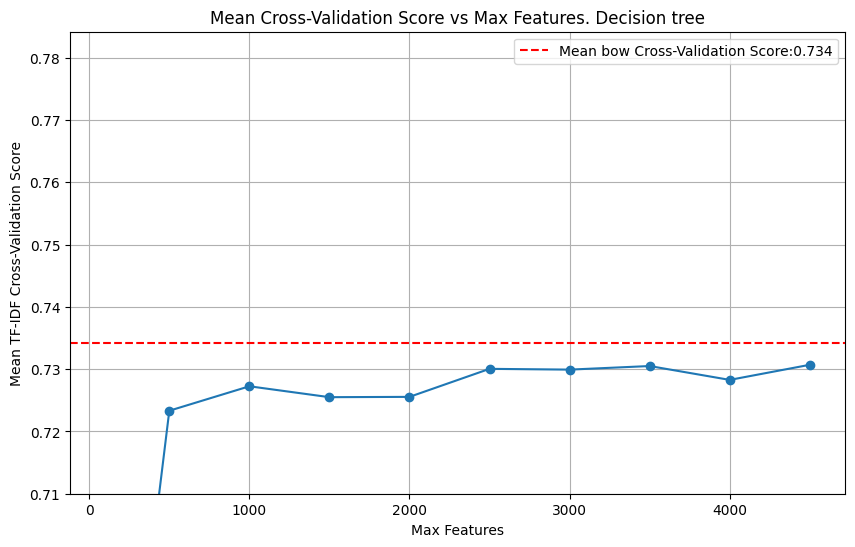

In [83]:
make_plot(model_dt, 'Decision tree')

My computer can't calculate naive bayes for bag of words

In [29]:
model = GaussianNB()

In [30]:
max_features_values, mean_scores = prepare_plot_data(model)

Max Features: 100, Mean Cross-Validation Score: 0.698
Max Features: 500, Mean Cross-Validation Score: 0.798
Max Features: 1000, Mean Cross-Validation Score: 0.811
Max Features: 1500, Mean Cross-Validation Score: 0.812
Max Features: 2000, Mean Cross-Validation Score: 0.81
Max Features: 2500, Mean Cross-Validation Score: 0.809
Max Features: 3000, Mean Cross-Validation Score: 0.807
Max Features: 3500, Mean Cross-Validation Score: 0.806
Max Features: 4000, Mean Cross-Validation Score: 0.803
Max Features: 4500, Mean Cross-Validation Score: 0.8


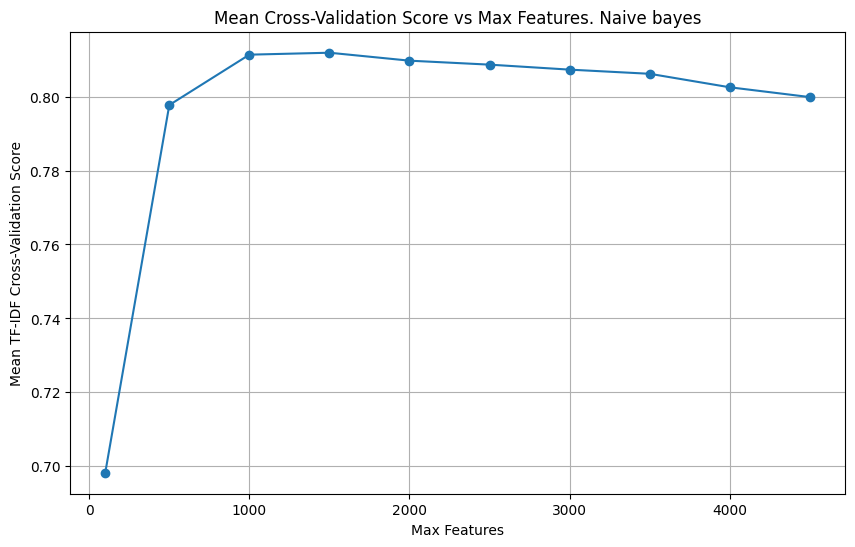

In [31]:
plt.figure(figsize=(10, 6))
plt.plot(max_features_values, mean_scores, marker='o')
plt.title(f'Mean Cross-Validation Score vs Max Features. Naive bayes')
plt.xlabel('Max Features')
plt.ylabel('Mean TF-IDF Cross-Validation Score')
plt.grid(True)
plt.show()

In [46]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)

In [50]:
# Define the values of max_features to try
max_features_values = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500]

# Dictionary to store results
results = {}

# Loop over max_features values and compute cross-validation scores
for max_features in max_features_values:
    tfidf_vectorizer.set_params(max_features=max_features)
    X_train_tfidf_vector =  tfidf_vectorizer.fit_transform(train_data_tokens['tokens']).toarray()
    tfidf_matrix_test = tfidf_vectorizer.transform(test_data_tokens['tokens'])
    X_test_tfidf_vector = tfidf_matrix_test.toarray()
    model = LogisticRegression()
    model.fit(X_train_tfidf_vector, y_train)
    scores = cross_val_score(model, X_train_tfidf_vector, y_train, cv=5, n_jobs=-1)
    results[max_features] = scores.mean()

# Print the results
for max_features, mean_score in results.items():
    print(f"Max Features: {max_features}, Mean Cross-Validation Score: {mean_score}")

Max Features: 100, Mean Cross-Validation Score: 0.7197000000000001
Max Features: 500, Mean Cross-Validation Score: 0.832575
Max Features: 1000, Mean Cross-Validation Score: 0.8564499999999999
Max Features: 1500, Mean Cross-Validation Score: 0.8665999999999998
Max Features: 2000, Mean Cross-Validation Score: 0.8715249999999999
Max Features: 2500, Mean Cross-Validation Score: 0.874925
Max Features: 3000, Mean Cross-Validation Score: 0.87715
Max Features: 3500, Mean Cross-Validation Score: 0.879175
Max Features: 4000, Mean Cross-Validation Score: 0.881075
Max Features: 4500, Mean Cross-Validation Score: 0.88235


In [64]:
max_features_values = list(results.keys())
mean_scores = list(results.values())
bow_score = 0.885

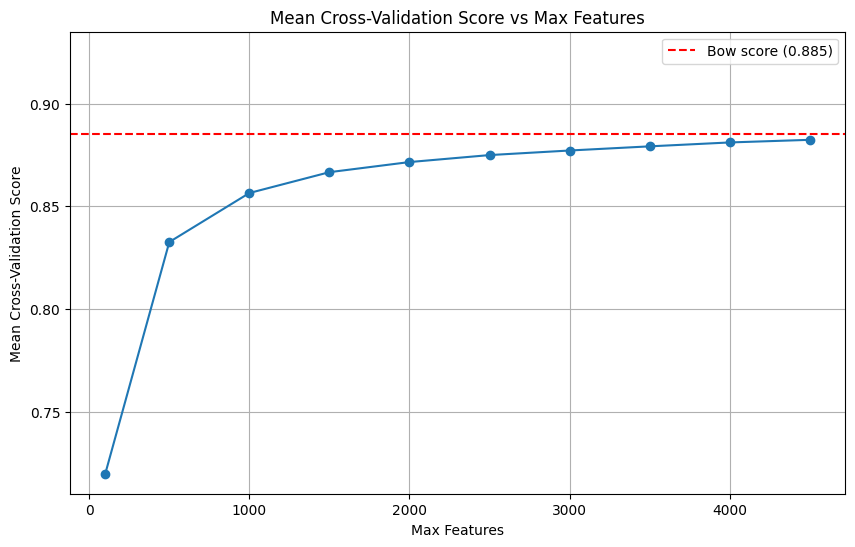

In [65]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(max_features_values, mean_scores, marker='o')
plt.title('Mean Cross-Validation Score vs Max Features')
plt.xlabel('Max Features')
plt.ylabel('Mean TF-IDF Cross-Validation Score')
plt.axhline(y=bow_score, color='red', linestyle='--', label=f'Mean bow Cross-Validation Score: {round(bow_score, 2)}')
plt.legend()
plt.ylim(0.71, bow_score + 0.05)  # Set your desired y-axis bounds
plt.grid(True)
plt.show()

I will use max_features = 2000

## Comparing max_features = 2000 and bag of words

In [28]:
def calc_metrics(model, vectors):
  prediction = model.predict(vectors)
  accuracy = accuracy_score(y_test, prediction)
  print(f"Accuracy: {round(accuracy*100, 1)}%")

  pos_label = 'negative'

  recall = recall_score(y_test, prediction, pos_label=pos_label)
  print(f"Recall: {round(recall*100,1)}%")
  f1 = f1_score(y_test, prediction, pos_label=pos_label)
  print(f"F1-score: {round(f1*100, 1)}%")

In [23]:
bow_vec = CountVectorizer()
X_train_bow = bow_vec.fit_transform(X_train).toarray()
X_test_bow = bow_vec.transform(X_test).toarray()
tfidf_vec = TfidfVectorizer (max_features=2000, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

In [29]:
logreg_bow = LogisticRegression(max_iter = 1000, random_state = 42)
logreg_bow.fit(X_train_bow, y_train)

KeyboardInterrupt: 

In [ ]:
logreg_tfidf = LogisticRegression(max_iter = 1000, random_state = 42)
logreg_tfidf.fit(X_test_tfidf, y_test)

In [ ]:
calc_metrics(logreg_bow, X_test_bow)

In [ ]:
calc_metrics(logreg_tfidf, X_test_tfidf)

In [ ]:
dt_bow = DecisionTreeClassifier(max_depth=20, random_state = 42)
dt_bow.fit(X_train_bow, y_train)

In [ ]:
dt_tfidf = DecisionTreeClassifier(max_depth=20, random_state = 42)
dt_tfidf.fit(X_test_tfidf, y_test)

In [ ]:
calc_metrics(dt_bow, X_test_bow)

In [ ]:
calc_metrics(dt_tfidf, X_test_tfidf)

Logistic regression seems to be one of the fastest algorithm and it has the best accuracy, and I will make my calculations based on this model in train.py